In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

In [2]:
!ls


best_circle_imgs
best_so_far.png
best_X_imgs
last_population_11k_with_sigmas.npy
last_population_30k_with_sigmas.npy
last_population.npy
last_sigmas_11k.npy
last_sigmas_30k.npy
last_sigmas.npy
Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg
population_30k_kindaok.npy
population_continuation_with_sigmas.npy
projekt.ipynb
README.md
result_30k.png
sigmas_continuation_with_sigmas.npy
todo.txt


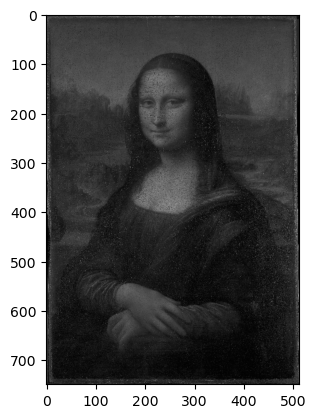

In [3]:
resize_to=512
target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
#Image.open('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg')
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255

plt.imshow(target_img, cmap='gray')
plt.show()

# define circles

In [4]:
class Circle:
    def __init__(self, cords, r, o, rgb, image_shape=(381, 256, 3)):
        self.x=cords[0] 
        self.y=cords[1]
        
        self.radius=r
        self.opacity=o
        self.rgb=rgb
       # self.g=rgb[1]
       # self.b=rgb[2]
        
        self.img_shape=image_shape
    def get_patch(self):
        return plt.Circle((self.x, self.y), 
                          radius=self.radius, 
                          alpha=self.opacity,
                          color=self.rgb)
    def draw_cv2(self, X):
        return cv2.circle(X, 
                  (self.x, self.y), 
                  self.radius, 
                  self.rgb,
                  thickness=-1)
        

In [5]:
def random_circle(max_radius=target_img.shape[1]):
    cords_seed=np.random.random(2)
    cords=(int(cords_seed[0]*target_img.shape[1]),
           int(cords_seed[1]*target_img.shape[0]))
    r=int(np.random.random()*100)
    o=np.random.random()
    rgb=np.random.random(3)
    return Circle(cords, r, o, rgb)

In [6]:

no_circles=100
# each circle has LOCATION (x,y), RADIUS, OPACITY, COLOUR (rgb), 
circles=[]
for i in range(no_circles):
    circles.append(random_circle())

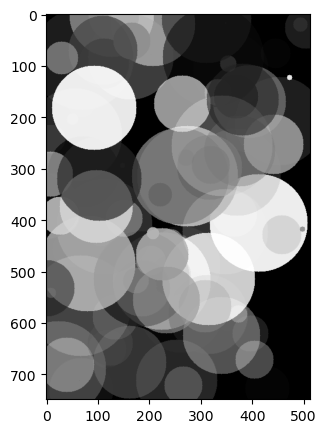

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

X=np.zeros(target_img.shape)
for c in circles:
  #  circle_img=X.copy()
    circle_img=c.draw_cv2(X.copy())
    X=cv2.addWeighted(X, 1-c.opacity, circle_img, c.opacity, 0)

plt.imshow(X, cmap='gray')
plt.show()

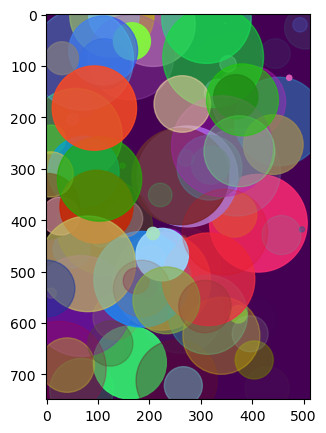

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))


X=np.zeros(target_img.shape)
ax.imshow(X)
for c in circles:
    ax.add_patch(c.get_patch())
plt.show()

# ES

In [12]:
def draw_individual(X_img, gray=True):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.show()
def save_individual_img(X_img, gray=True, no_iter=0, dir_path='./best_circle_imgs/'):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.savefig(dir_path+f'iter_{no_iter}')
    plt.show()

In [10]:
class EvoulationStrategy:
    def __init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
        
        self.chromosome_length=initial_chromosome_length
        self.initial_chromosome_length=initial_chromosome_length
        self.genotype_length=genotype_length
        self.population_size=population_size
    
        self.target_img=target_img
        self.max_radius=np.sqrt(pow(self.target_img.shape[0],2)+pow(self.target_img.shape[1], 2))/2
        self.gray=gray
    
        self.population=None#np.empty((self.population_size, self.initil_chromosome_length, self.genotype_length))
        self.sigmas=None#np.empty((self.population_size, self.genotype_length))
        self.curr_iter=0
        self.evals=None
        
    def random_circle(self, max_radius_scale=1.0, max_opacity_scale=1.0):
        if self.gray:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
            lows[2]=0.25*max_radius_scale
            highs[2]=1.0*max_radius_scale
            highs[3]=1.0* max_opacity_scale

            circle=np.random.uniform(lows, highs, self.genotype_length)
        else:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
            lows[2]=0.25*max_radius_scale
            highs[2]=1.0*max_radius_scale
            highs[3]=1.0* max_opacity_scale

            circle=np.random.uniform(lows, highs, self.genotype_length)
        return circle

    def random_individual(self, chrom_length, max_radius_scale=1.0,  max_opacity_scale=1.0):
        indiv = np.zeros((chrom_length, self.genotype_length))

        for i in range(chrom_length):
            indiv[i] = self.random_circle(max_radius_scale=max_radius_scale, 
                                     max_opacity_scale=max_opacity_scale)
        return indiv

    def random_population(self, chrom_length,
                          max_radius_scale=1.0, max_opacity_scale=1.0):
        population = np.zeros((self.population_size, chrom_length, self.genotype_length))
        for i in range(self.population_size):
            population[i] = self.random_individual(chrom_length,
                                              max_radius_scale, max_opacity_scale)
        return population

    def represent_individual(self, X):
        X_img=np.zeros(self.target_img.shape)
        for c in X:
            #[x, y, radius, opacity, r, g, b]
            x=int(c[0]*self.target_img.shape[1])
            y=int(c[1]*self.target_img.shape[0])
            radius=int(c[2]*self.max_radius)
            opacity=c[3]
            rgb=c[4:]
            circle_img=cv2.circle(X_img.copy(), 
                                  (x, y), 
                                  radius, 
                                  rgb,
                                  thickness=-1)
            X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
        return X_img
    
    def f(self, X_img):
        #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
        pom = self.target_img - X_img
        return np.sum(pom*pom)
    def evaluate_individual(self, solutions, evals, i):
        evals[i]=self.f(self.represent_individual(solutions[i]))
        
    def mutate_X(self, X, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, X.shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(X.shape[0]), no_figures_to_mutate, replace=False)

        clip_lows=np.zeros(X.shape[1])
      #  clip_highs=np.ones(solutions[i].shape[1])
        clip_lows[2]=1/64 # minimal radius
        clip_lows[3]=1/64 # miniaml opacity

        X[figures_to_mutate]=np.clip(X[figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                             X.shape[1]))-0.5)*sigmas, 
                                     clip_lows, 1)
        return X

    def mutate_sigmas(self, sigmas, scale=1e-3, mut_prob=0.5):
        mutation_indices = (np.random.random(sigmas.shape) < mut_prob).astype(float)
        sigmas += mutation_indices * np.random.normal(loc=0, scale=scale, size=sigmas.shape)
        sigmas= np.clip(sigmas, 1e-4, 1e-1)
        return sigmas

    def mutate_X_thred(self, solutions, i, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, solutions[i].shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(solutions[i].shape[0]), no_figures_to_mutate, replace=False)

        clip_lows=np.zeros(solutions[i].shape[1])
      #  clip_highs=np.ones(solutions[i].shape[1])
        clip_lows[2]=1/64 # minimal radius
        clip_lows[3]=1/64 # miniaml opacity

        solutions[i,figures_to_mutate]=np.clip(solutions[i,figures_to_mutate]+(np.random.random((
                                                                   no_figures_to_mutate,
                                                                   solutions[i].shape[1]))-0.5)*sigmas[i], 
                                               clip_lows, 1)

    def train(self,
            number_of_iterations=30000, 
            number_of_parents=6, 
            number_of_offspring_per_parent=3, 
            max_chromosome_length=256,
            initial_sigma_scale=5e-2,
            add_cricle_threshold=5e-3,
            log_frequency=1,
            pararell=True
        ):
        best_solution = np.zeros((max_chromosome_length, self.genotype_length))
        best_solution_objective_value = np.inf


        log_objective_values = np.zeros((number_of_iterations, 4))
        log_best_solutions = []#np.zeros((number_of_iterations, max_chromosome_length, genotype_length))
       # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

        # generating an initial population
        if not isinstance(self.population, np.ndarray):
            self.population=self.random_population(self.chromosome_length)
        # SIGMAS individualXcircle parameters (mutation scale)
        if not isinstance(self.sigmas, np.ndarray):
            self.sigmas = initial_sigma_scale * np.ones((self.population_size, self.genotype_length))

        # evaluating the objective function on the current population
        self.evals=np.ones(self.population_size)
        if pararell:
            threads=[]
            for i in range(self.population_size):
                t=th.Thread(target=self.evaluate_individual, args=[self.population, self.evals, i])
                t.start()
                threads.append(t)
            for t in threads:
                t.join()
        else:
            self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])

        try:
            times_circles_were_added=1+self.population.shape[1]//(2*self.initial_chromosome_length) # initial creation of population
            last_update_iter=0
           # start_mutations_scale=mutation_scale
            for no_iter in progress_bar(range(number_of_iterations)):
                self.curr_iter=no_iter
                # selecting the parent indices by the roulette wheel method
                # MAXIMIZE
                #fitness_values = current_population_objective_values - current_population_objective_values.min()
                # MINIMIZE
                fitness_values = self.evals.max() - self.evals
                if fitness_values.sum() > 0:
                    fitness_values = fitness_values / fitness_values.sum()
                else:
                    fitness_values = 1.0 / self.population_size * np.ones(self.population_size)
                parent_indices = np.random.choice(self.population_size, 
                                                  number_of_parents, True, fitness_values).astype(np.int64)

                # creating the children population by Global Intermediere Recombination
                children_list=[]
                children_sigmas_list=[]
                for i in range(number_of_offspring_per_parent):
                    children_list.append(self.population[parent_indices].copy())          
                    children_sigmas_list.append(self.sigmas[parent_indices].copy())          
                children_population_solutions = np.vstack(children_list)
                children_population_sigmas = np.vstack(children_sigmas_list)

                children_population_sigmas=self.mutate_sigmas(children_population_sigmas)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.mutate_X_thred, args=[children_population_solutions, 
                                                                      i, children_population_sigmas])
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    for i in range(children_population_solutions.shape[0]):
                        children_population_solutions[i]=self.mutate_X(children_population_solutions[i], 
                                                                  children_population_sigmas[i])

                # evaluating the objective function on the children population
                children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.evaluate_individual, args=[children_population_solutions,
                                                                           children_population_objective_values,
                                                                           i] )
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    children_population_objective_values = [self.f(self.represent_individual(X)) for X in children_population_solutions]

                # replacing the current population by (Mu + Lambda) Replacement
                self.evals = np.hstack([self.evals, 
                                        children_population_objective_values])
                self.population = np.vstack([self.population, 
                                             children_population_solutions])
                self.sigmas = np.vstack([self.sigmas, 
                                         children_population_sigmas])

                I = np.argsort(self.evals)#[::-1]
                self.population = self.population[I[:self.population_size], :]
                self.sigmas = self.sigmas[I[:self.population_size], :]
                self.evals = self.evals[I[:self.population_size]]

                # recording some statistics
                if best_solution_objective_value > self.evals[0]:
                    best_solution = self.population[0, :]
                    best_solution_objective_value = self.evals[0]

                log_objective_values[no_iter, :] = [self.evals.min(), 
                                                    self.evals.max(),
                                                    self.evals.mean(), 
                                                    self.evals.std()]

                if np.mod(no_iter, log_frequency) == 0 or no_iter==number_of_iterations-1:

                    np.save('/kaggle/working/population', self.population)
                    np.save('/kaggle/working/sigmas', self.sigmas)
                    log_best_solutions.append(self.population[0, :])
                    print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                        log_objective_values[no_iter, 0], 
                                                                                        log_objective_values[no_iter, 2]))
                    #draw_individual(represent_individual(best_solution), gray)
                    save_individual_img(self.represent_individual(best_solution), self.gray, no_iter=no_iter)
                    np.save('/kaggle/working/population_continuation_with_sigmas',self.population)
                    np.save('/kaggle/working/sigmas_continuation_with_sigmas',self.sigmas)

                    if no_iter-last_update_iter>=times_circles_were_added*400 and \
                       no_iter>2*log_frequency and \
                       self.population.shape[1]<max_chromosome_length:

                        prev=np.mean(log_objective_values[no_iter-2*log_frequency:no_iter-log_frequency])
                        curr=np.mean(log_objective_values[no_iter-log_frequency:no_iter+1])
                        if (prev-curr)/prev < add_cricle_threshold: # ADD CIRCLES

                            last_update_iter=no_iter
                            times_circles_were_added+=1
                            best_solution_objective_value=np.inf
                          #  mutation_scale=start_mutations_scale/times_circles_were_added

                            radius_scale=1/(2*times_circles_were_added)
                            if radius_scale<1/16:
                                radius_scale=1/16

                            new_pop=self.random_population(chrom_length=2*self.initial_chromosome_length, 
                                                           max_radius_scale=radius_scale,
                                                           max_opacity_scale=0.5)
                            self.population=np.concatenate([self.population, new_pop], 
                                                            axis=1)
                            print(f'Added more circles of radius_scale={radius_scale}.\n New population shape: {self.population.shape}')
                            print('Sigmas: ', self.sigmas)
                            if pararell:
                                threads=[]
                                for i in range(self.population_size):
                                    t=th.Thread(target=self.evaluate_individual, args=[self.population,
                                                                                      self.evals, 
                                                                                      i])
                                    t.start()
                                    threads.append(t)
                                for t in threads:
                                    t.join()
                            else:
                                self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])


        except KeyboardInterrupt:
            print('Interrupted')
        return (best_solution_objective_value, best_solution, 
                log_objective_values, log_best_solutions)

In [77]:
prev_pop=np.load('./last_population_11k_with_sigmas.npy')
prev_sigmas=np.load('./last_sigmas_11k.npy')
prev_pop.shape, prev_sigmas.shape

((32, 104, 5), (32, 5))

  0%|                                                 | 0/30000 [00:00<?, ?it/s]

Iteration 0000 : best score = 1335.95794422, mean score = 1337.23345249.


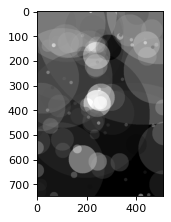

  0%|                                    | 100/30000 [04:56<24:55:00,  3.00s/it]

Iteration 0100 : best score = 1335.48185967, mean score = 1336.34984436.


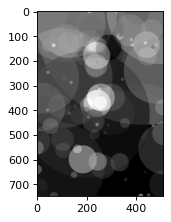

  1%|▏                                   | 200/30000 [09:53<24:49:52,  3.00s/it]

Iteration 0200 : best score = 1335.14194694, mean score = 1335.68047495.


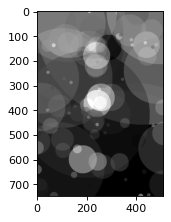

  1%|▎                                   | 300/30000 [14:51<24:10:48,  2.93s/it]

Iteration 0300 : best score = 1332.53108962, mean score = 1333.15853127.


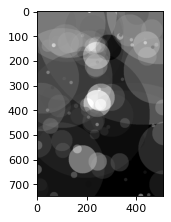

  1%|▍                                   | 400/30000 [19:44<23:46:17,  2.89s/it]

Iteration 0400 : best score = 1330.87834338, mean score = 1331.92640129.


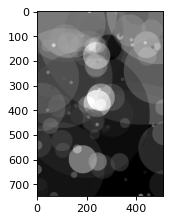

  2%|▌                                   | 500/30000 [24:36<23:44:44,  2.90s/it]

Iteration 0500 : best score = 1329.08034645, mean score = 1330.31482990.


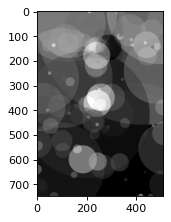

  2%|▋                                   | 600/30000 [29:27<23:40:20,  2.90s/it]

Iteration 0600 : best score = 1327.33259329, mean score = 1328.71712926.


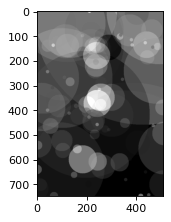

  2%|▊                                   | 700/30000 [34:17<23:34:21,  2.90s/it]

Iteration 0700 : best score = 1326.41182771, mean score = 1326.88726365.


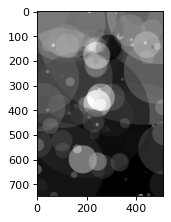

  3%|▉                                   | 800/30000 [39:07<23:30:28,  2.90s/it]

Iteration 0800 : best score = 1325.22729376, mean score = 1326.13041811.


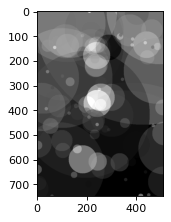

  3%|█                                   | 900/30000 [43:57<23:27:23,  2.90s/it]

Iteration 0900 : best score = 1323.98196391, mean score = 1325.08165511.


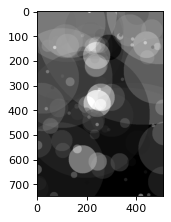

Added more circles of radius_scale=0.25.
 New population shape: (32, 120, 5)
Sigmas:  [[0.03320306 0.03485204 0.0690257  0.06325685 0.04219684]
 [0.03360039 0.03485204 0.06812468 0.06325685 0.04219684]
 [0.03362999 0.03457345 0.06786182 0.06325685 0.04078403]
 [0.03362999 0.03457345 0.06786182 0.06325685 0.0409421 ]
 [0.03386219 0.03575936 0.06812468 0.06384717 0.04219684]
 [0.03386219 0.03575936 0.06812468 0.06325685 0.04219684]
 [0.03386219 0.03575936 0.06812468 0.06325685 0.04219684]
 [0.03504115 0.03498149 0.06786182 0.06325685 0.04138263]
 [0.03504115 0.03498149 0.06786182 0.06325685 0.04214647]
 [0.03362999 0.03457345 0.06786182 0.06325685 0.04078403]
 [0.03386219 0.03575936 0.06812468 0.0643386  0.04219684]
 [0.03504115 0.03498149 0.06786182 0.06328163 0.04138263]
 [0.03351485 0.03579566 0.06812468 0.06325685 0.04091396]
 [0.03386219 0.03575936 0.06812468 0.06547587 0.04222054]
 [0.03504115 0.03498149 0.06786182 0.06325685 0.04138263]
 [0.03386219 0.03575936 0.06753664 0.0632675

  3%|█▏                                 | 1000/30000 [49:36<27:46:32,  3.45s/it]

Iteration 1000 : best score = 1616.29883650, mean score = 1633.55903263.


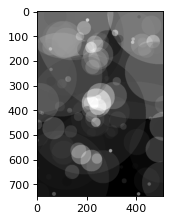

  4%|█▎                                 | 1100/30000 [55:13<26:52:47,  3.35s/it]

Iteration 1100 : best score = 1533.35907585, mean score = 1536.31855345.


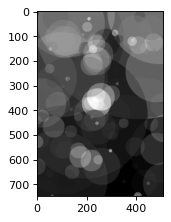

  4%|█▎                               | 1200/30000 [1:00:48<26:43:45,  3.34s/it]

Iteration 1200 : best score = 1510.12911172, mean score = 1512.89133245.


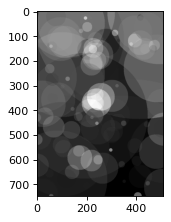

  4%|█▍                               | 1300/30000 [1:06:21<26:27:17,  3.32s/it]

Iteration 1300 : best score = 1476.01513194, mean score = 1481.59276420.


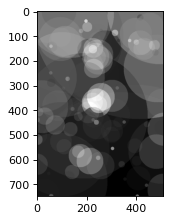

  5%|█▌                               | 1400/30000 [1:12:03<28:44:26,  3.62s/it]

Iteration 1400 : best score = 1454.09236591, mean score = 1457.21437900.


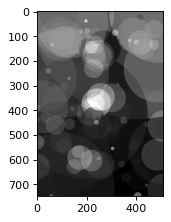

  5%|█▋                               | 1500/30000 [1:18:08<29:32:39,  3.73s/it]

Iteration 1500 : best score = 1434.90613764, mean score = 1438.06641519.


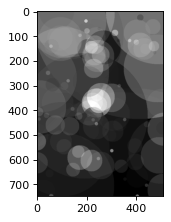

  5%|█▊                               | 1600/30000 [1:23:50<26:24:14,  3.35s/it]

Iteration 1600 : best score = 1423.12670613, mean score = 1426.80149776.


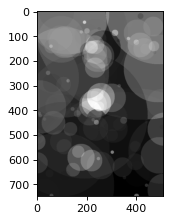

  6%|█▊                               | 1700/30000 [1:29:23<26:10:14,  3.33s/it]

Iteration 1700 : best score = 1411.40369855, mean score = 1415.12471834.


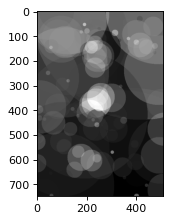

  6%|█▉                               | 1800/30000 [1:34:56<26:01:11,  3.32s/it]

Iteration 1800 : best score = 1398.33196101, mean score = 1403.73466504.


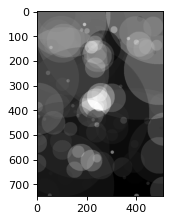

  6%|██                               | 1900/30000 [1:40:29<25:57:26,  3.33s/it]

Iteration 1900 : best score = 1390.28795911, mean score = 1394.42485355.


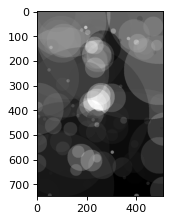

  7%|██▏                              | 2000/30000 [1:46:02<25:52:58,  3.33s/it]

Iteration 2000 : best score = 1383.14256685, mean score = 1385.45752285.


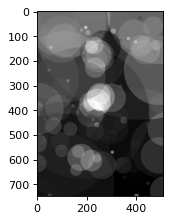

  7%|██▎                              | 2100/30000 [1:51:35<25:48:29,  3.33s/it]

Iteration 2100 : best score = 1377.13061533, mean score = 1379.11670306.


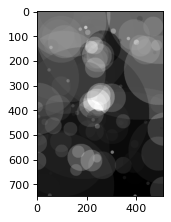

  7%|██▍                              | 2200/30000 [1:57:09<25:42:01,  3.33s/it]

Iteration 2200 : best score = 1371.43618605, mean score = 1374.63776258.


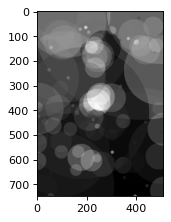

  8%|██▌                              | 2300/30000 [2:02:42<25:39:04,  3.33s/it]

Iteration 2300 : best score = 1368.86147571, mean score = 1369.77696293.


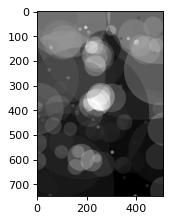

  8%|██▋                              | 2400/30000 [2:08:16<25:35:11,  3.34s/it]

Iteration 2400 : best score = 1362.97191322, mean score = 1365.38893887.


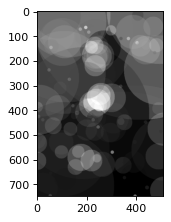

  8%|██▊                              | 2500/30000 [2:13:49<25:27:40,  3.33s/it]

Iteration 2500 : best score = 1360.22961776, mean score = 1361.66072097.


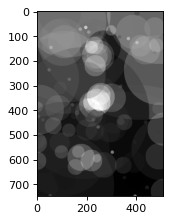

  9%|██▊                              | 2600/30000 [2:19:23<25:30:11,  3.35s/it]

Iteration 2600 : best score = 1357.58473566, mean score = 1358.52347618.


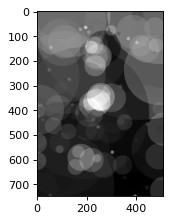

  9%|██▉                              | 2700/30000 [2:24:57<25:15:16,  3.33s/it]

Iteration 2700 : best score = 1353.86928190, mean score = 1355.45907840.


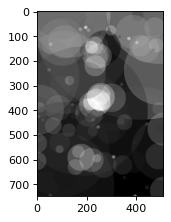

  9%|███                              | 2800/30000 [2:30:30<25:08:39,  3.33s/it]

Iteration 2800 : best score = 1350.52565505, mean score = 1352.02062741.


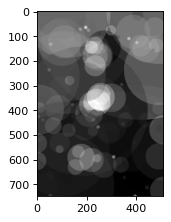

 10%|███▏                             | 2900/30000 [2:36:04<25:05:19,  3.33s/it]

Iteration 2900 : best score = 1348.73809669, mean score = 1350.17426651.


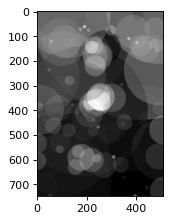

 10%|███▎                             | 3000/30000 [2:41:38<25:00:26,  3.33s/it]

Iteration 3000 : best score = 1344.30254569, mean score = 1345.86262554.


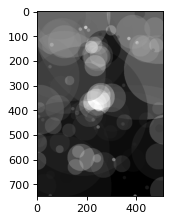

 10%|███▍                             | 3100/30000 [2:47:11<24:54:23,  3.33s/it]

Iteration 3100 : best score = 1340.82101467, mean score = 1341.77114423.


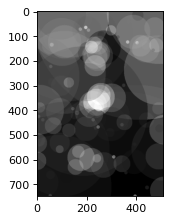

 11%|███▌                             | 3200/30000 [2:52:45<24:51:29,  3.34s/it]

Iteration 3200 : best score = 1335.33224120, mean score = 1337.73289553.


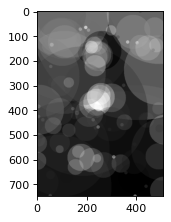

 11%|███▋                             | 3300/30000 [2:58:19<24:42:53,  3.33s/it]

Iteration 3300 : best score = 1330.47474615, mean score = 1332.40186077.


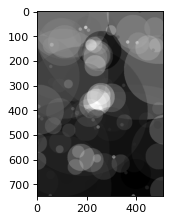

 11%|███▋                             | 3400/30000 [3:03:52<24:36:22,  3.33s/it]

Iteration 3400 : best score = 1325.25215701, mean score = 1327.84888850.


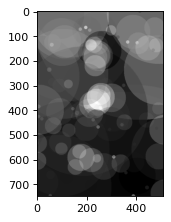

 12%|███▊                             | 3500/30000 [3:09:26<24:33:40,  3.34s/it]

Iteration 3500 : best score = 1321.04635862, mean score = 1323.12787012.


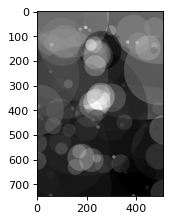

 12%|███▉                             | 3600/30000 [3:15:00<24:27:56,  3.34s/it]

Iteration 3600 : best score = 1316.95642656, mean score = 1320.43804894.


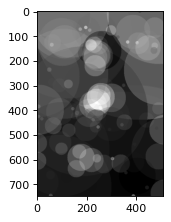

 12%|████                             | 3700/30000 [3:20:34<24:22:16,  3.34s/it]

Iteration 3700 : best score = 1312.58966731, mean score = 1315.51532586.


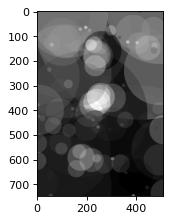

 13%|████▏                            | 3800/30000 [3:26:07<24:15:07,  3.33s/it]

Iteration 3800 : best score = 1309.84044725, mean score = 1311.62823122.


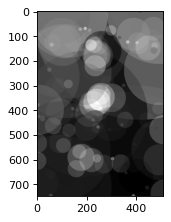

 13%|████▎                            | 3900/30000 [3:31:41<24:13:55,  3.34s/it]

Iteration 3900 : best score = 1308.58085844, mean score = 1309.82903633.


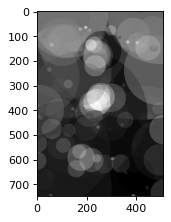

 13%|████▍                            | 4000/30000 [3:37:15<24:04:30,  3.33s/it]

Iteration 4000 : best score = 1307.07364543, mean score = 1308.28468638.


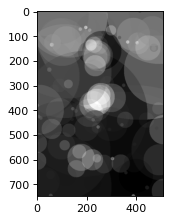

 14%|████▌                            | 4100/30000 [3:42:49<23:59:10,  3.33s/it]

Iteration 4100 : best score = 1305.02164902, mean score = 1306.33171433.


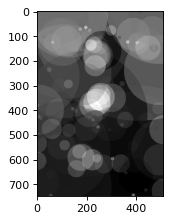

 14%|████▌                            | 4200/30000 [3:48:23<23:54:56,  3.34s/it]

Iteration 4200 : best score = 1303.58615072, mean score = 1304.53273676.


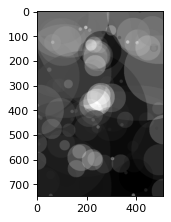

 14%|████▋                            | 4300/30000 [3:53:56<23:50:20,  3.34s/it]

Iteration 4300 : best score = 1301.85268911, mean score = 1303.01843809.


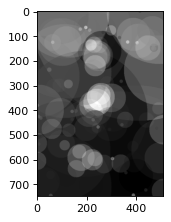

 15%|████▊                            | 4400/30000 [3:59:30<23:47:55,  3.35s/it]

Iteration 4400 : best score = 1301.33132647, mean score = 1301.93051745.


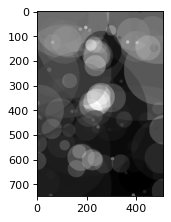

Added more circles of radius_scale=0.16666666666666666.
 New population shape: (32, 136, 5)
Sigmas:  [[0.03361808 0.04107449 0.07834746 0.05777736 0.05480005]
 [0.03431941 0.04164607 0.07947618 0.05625778 0.05363024]
 [0.03361808 0.04180257 0.07992204 0.05795889 0.05676351]
 [0.03431941 0.04012639 0.07947618 0.05625778 0.05363024]
 [0.03431941 0.04097355 0.07947618 0.05625778 0.05363024]
 [0.03361808 0.04180257 0.07920829 0.05795889 0.05676351]
 [0.03361808 0.04180257 0.07920829 0.05795889 0.05444786]
 [0.03193855 0.04123585 0.07761968 0.05961973 0.0555878 ]
 [0.03361808 0.04180257 0.07920829 0.05795889 0.0555878 ]
 [0.0333497  0.04180257 0.07853735 0.05836052 0.0556356 ]
 [0.03477148 0.04094623 0.08003471 0.05795889 0.05577649]
 [0.03337007 0.04199942 0.08244195 0.05795889 0.05649423]
 [0.03361808 0.04261993 0.07920829 0.05795889 0.0555878 ]
 [0.03361808 0.04159866 0.08054236 0.05795889 0.05676351]
 [0.03477148 0.04157597 0.08023544 0.05761776 0.05389301]
 [0.03477148 0.04157597 0.080

 15%|████▉                            | 4500/30000 [4:05:51<26:46:22,  3.78s/it]

Iteration 4500 : best score = 1557.95867910, mean score = 1566.56360123.


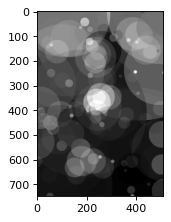

 15%|█████                            | 4600/30000 [4:12:09<26:40:13,  3.78s/it]

Iteration 4600 : best score = 1485.50046397, mean score = 1494.65612701.


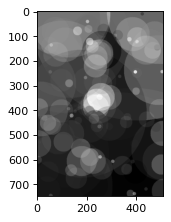

 16%|█████▏                           | 4700/30000 [4:18:27<26:35:28,  3.78s/it]

Iteration 4700 : best score = 1451.49622581, mean score = 1454.46084838.


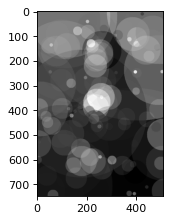

 16%|█████▎                           | 4800/30000 [4:24:45<26:25:55,  3.78s/it]

Iteration 4800 : best score = 1437.83775272, mean score = 1440.82457761.


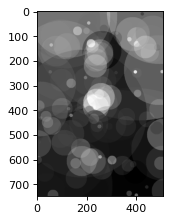

 16%|█████▍                           | 4900/30000 [4:31:03<26:19:18,  3.78s/it]

Iteration 4900 : best score = 1426.49161938, mean score = 1432.88912538.


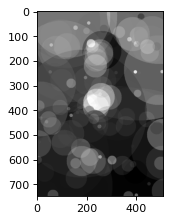

 17%|█████▌                           | 5000/30000 [4:37:22<26:18:09,  3.79s/it]

Iteration 5000 : best score = 1411.23087964, mean score = 1415.41976007.


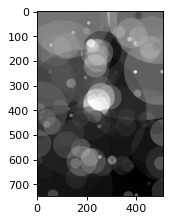

 17%|█████▌                           | 5100/30000 [4:43:39<26:05:16,  3.77s/it]

Iteration 5100 : best score = 1398.15282956, mean score = 1401.39236219.


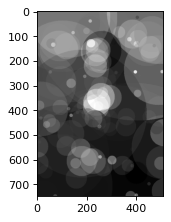

 17%|█████▋                           | 5200/30000 [4:49:58<26:03:52,  3.78s/it]

Iteration 5200 : best score = 1392.53949030, mean score = 1395.49360895.


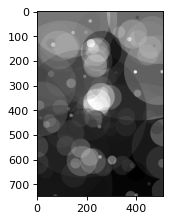

 18%|█████▊                           | 5300/30000 [4:56:16<25:56:39,  3.78s/it]

Iteration 5300 : best score = 1386.64407329, mean score = 1388.39930080.


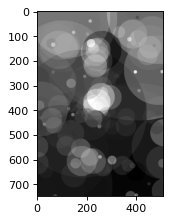

 18%|█████▉                           | 5400/30000 [5:02:37<27:09:59,  3.98s/it]

Iteration 5400 : best score = 1380.04497428, mean score = 1382.84592019.


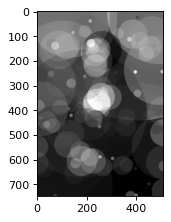

 18%|██████                           | 5500/30000 [5:09:13<28:31:53,  4.19s/it]

Iteration 5500 : best score = 1378.16481486, mean score = 1379.29429541.


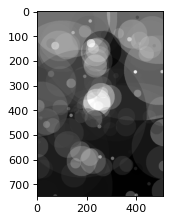

 19%|██████▏                          | 5600/30000 [5:16:13<28:14:33,  4.17s/it]

Iteration 5600 : best score = 1372.26675924, mean score = 1374.63039857.


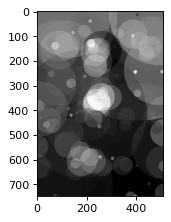

 19%|██████▎                          | 5700/30000 [5:23:01<28:53:27,  4.28s/it]

Iteration 5700 : best score = 1363.18057368, mean score = 1367.24053781.


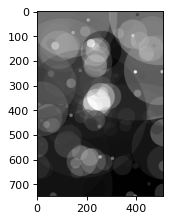

 19%|██████▍                          | 5800/30000 [5:30:05<28:24:12,  4.23s/it]

Iteration 5800 : best score = 1356.44375292, mean score = 1359.09705966.


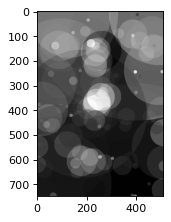

 20%|██████▍                          | 5900/30000 [5:37:00<28:20:01,  4.23s/it]

Iteration 5900 : best score = 1355.80357691, mean score = 1356.68989924.


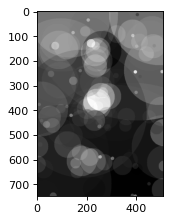

 20%|██████▌                          | 6000/30000 [5:44:04<28:24:32,  4.26s/it]

Iteration 6000 : best score = 1352.60088963, mean score = 1355.33197996.


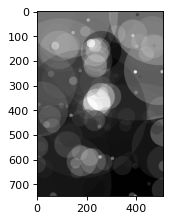

 20%|██████▋                          | 6100/30000 [5:51:11<28:07:40,  4.24s/it]

Iteration 6100 : best score = 1348.04652332, mean score = 1350.16299671.


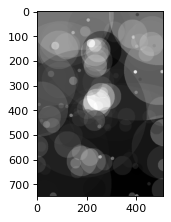

 21%|██████▊                          | 6177/30000 [5:56:35<22:55:14,  3.46s/it]

Interrupted


In [80]:
'''
__init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
train(number_of_iterations=30000, 
              number_of_parents=6, 
              number_of_offspring_per_parent=3, 
              max_chromosome_length=256,
              initial_sigma_scale=5e-2,
              log_frequency=1,
              pararell=True
             ):
'''

es_model=EvoulationStrategy(initial_chromosome_length=8,
                           genotype_length=5,
                           population_size=32,
                           target_img=target_img,
                           gray=True)

#es_model.population=prev_pop.copy()
#es_model.sigmas=prev_sigmas.copy()

best_solution_objective_value, best_solution, \
log_objective_values, log_best_solutions = es_model.train(number_of_iterations=30000,
                                                          number_of_parents=6, 
                                                          number_of_offspring_per_parent=6, 
                                                          max_chromosome_length=256,
                                                          initial_sigma_scale=5e-2,
                                                          add_cricle_threshold=1e-4,
                                                          log_frequency=100)

In [81]:
np.save('./population_continuation_with_sigmas',es_model.population)
np.save('./sigmas_continuation_with_sigmas',es_model.sigmas)

In [640]:
np.save('./last_population', population)
np.save('./last_sigmas', sigmas)

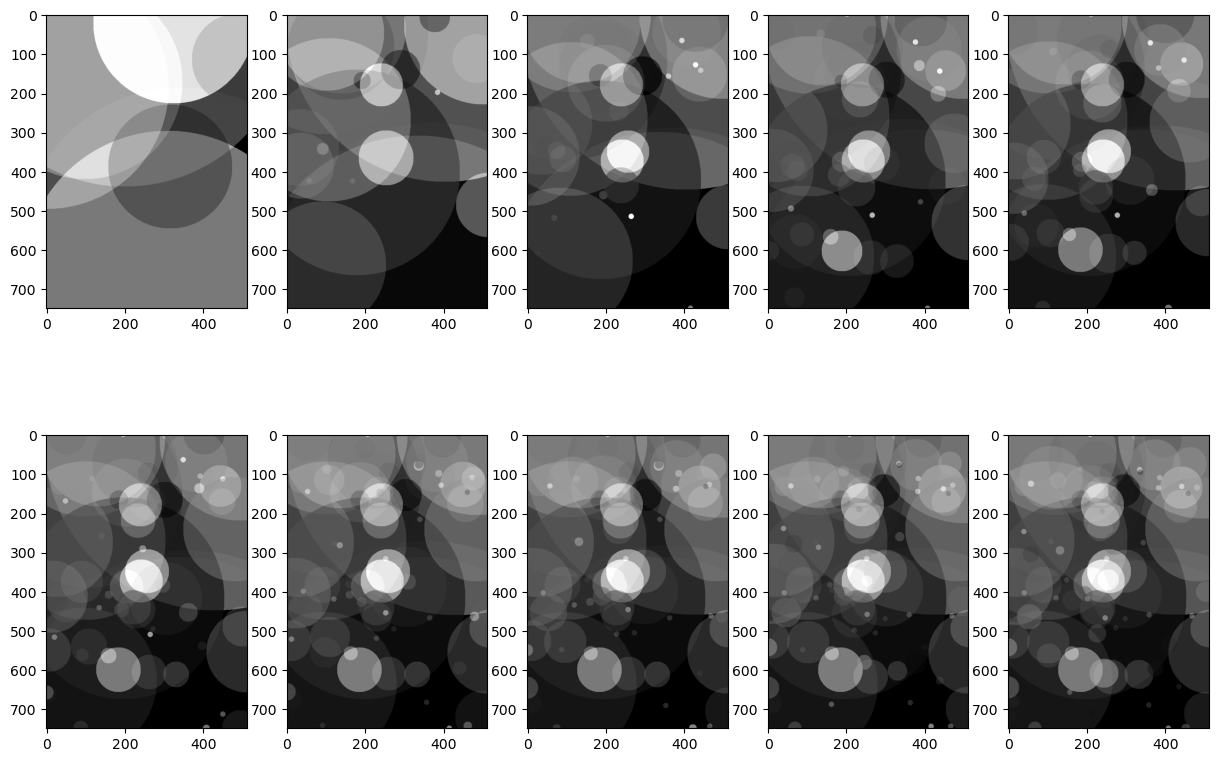

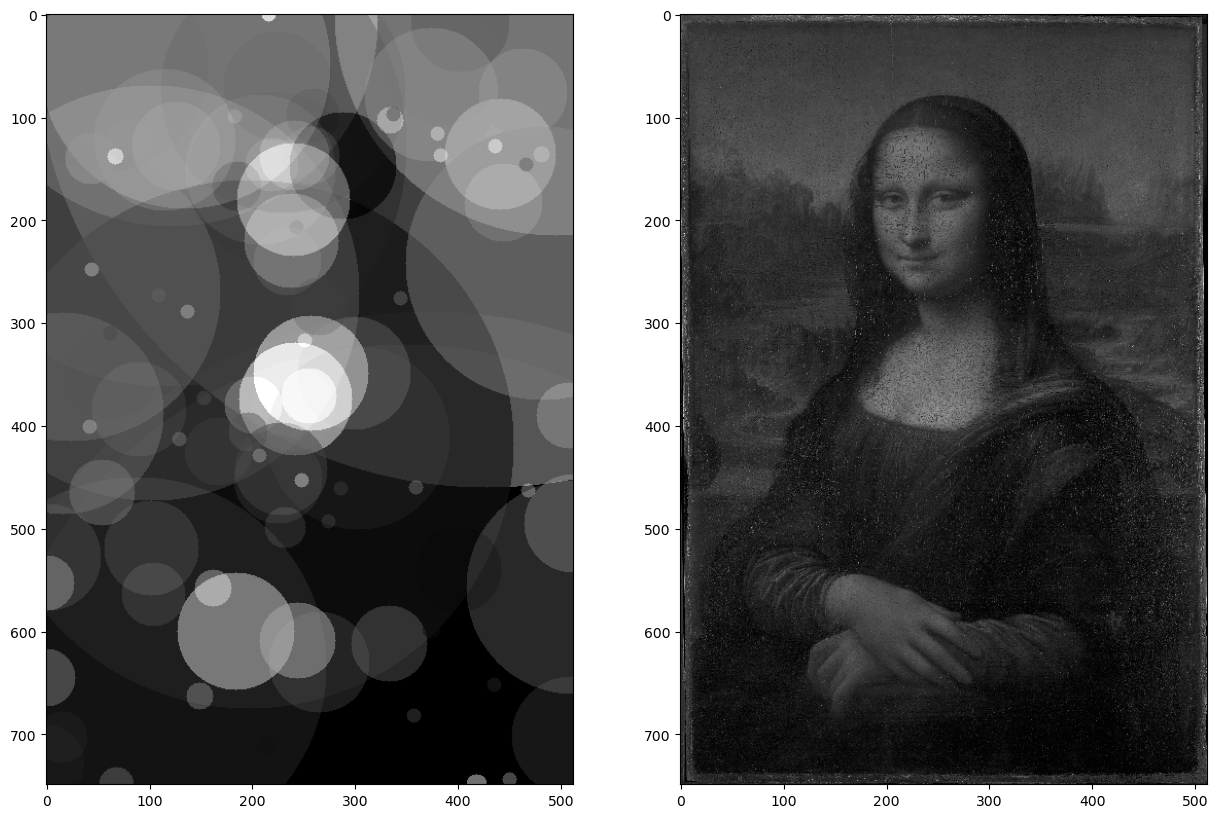

In [642]:
mod_val=(10+len(log_best_solutions))//10

fig, axs = plt.subplots(2, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions[:-1]):
    if i%mod_val==0:
        axs[row_counter, col_counter].imshow(represent_individual(X), cmap='gray')
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(represent_individual(best_solution), cmap='gray')
axs[1].imshow(target_img, cmap='gray')
plt.show()

/tmp/ipykernel_8775/1906222271.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(log_objective_values[:,0]))


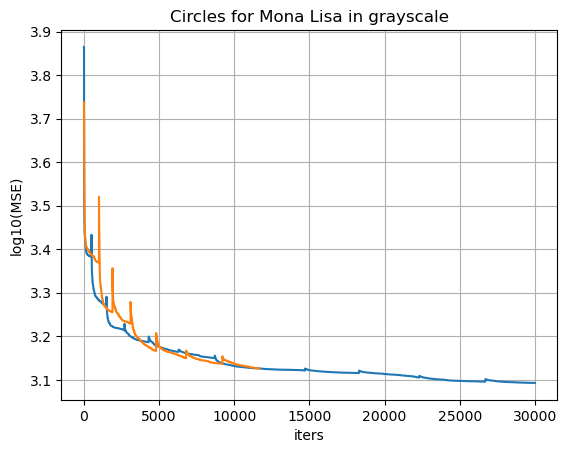

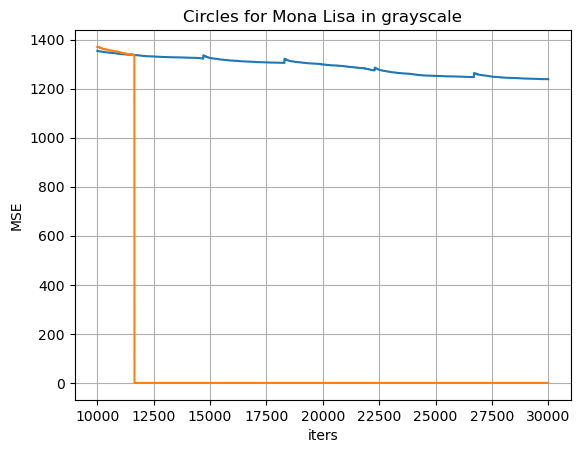

In [645]:
plt.plot(np.log10(log_values_30k[:,0]))
plt.plot(np.log10(log_objective_values[:,0]))
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('log10(MSE)')
plt.xlabel('iters')

plt.show()

plt.plot(np.arange(10000, 30000), (log_values_30k[10000:,0]))
plt.plot(np.arange(10000, 30000), (log_objective_values[10000:,0]))
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('MSE')
plt.xlabel('iters')

plt.show()

# OLD

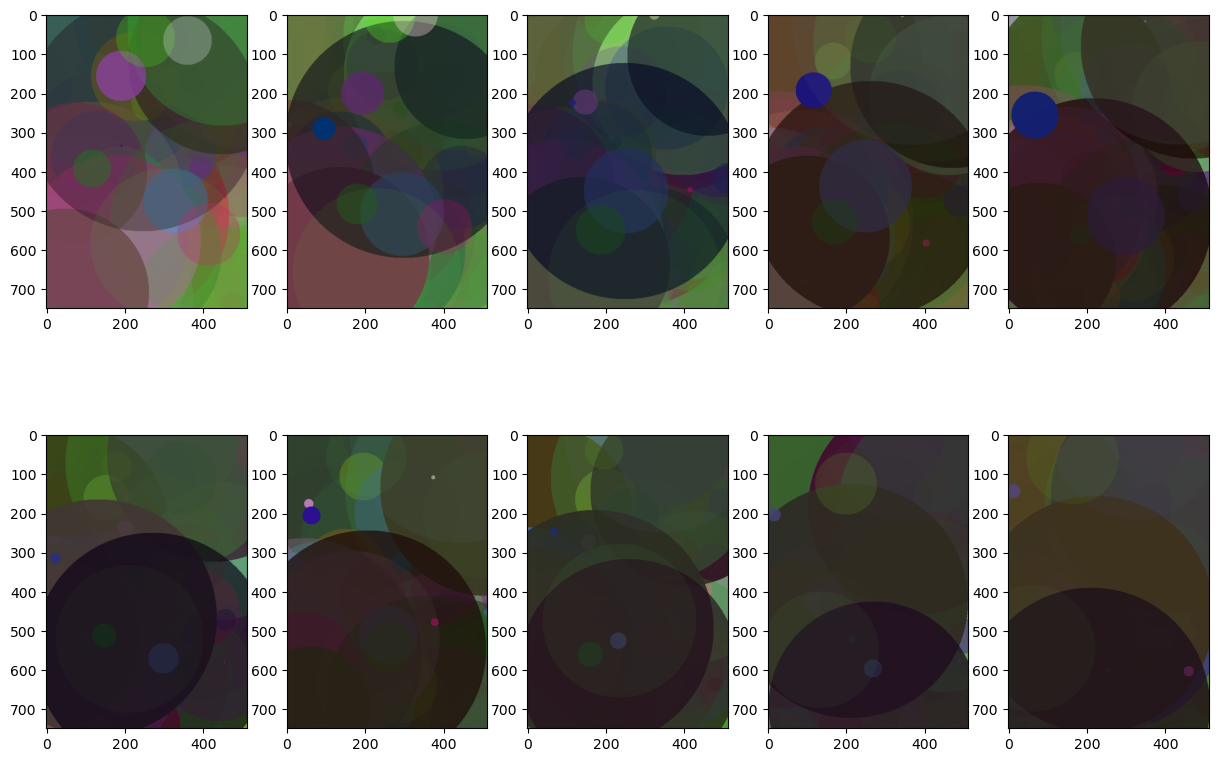

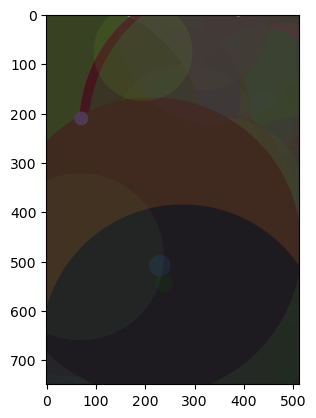

In [49]:

fig, axs = plt.subplots(log_best_solutions.shape[0]//50, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions):
    if i%10==0:
        axs[row_counter, col_counter].imshow(represent_individual(X))
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()
draw_individual(represent_individual(best_solution))

In [13]:
max_radius=np.sqrt(pow(target_img.shape[0],2)+pow(target_img.shape[1], 2))/2

def represent_individual(X):
    X_img=np.zeros(target_img.shape)
    for c in X:
        #[x, y, radius, opacity, r, g, b]
        x=int(c[0]*target_img.shape[1])
        y=int(c[1]*target_img.shape[0])
        radius=int(c[2]*max_radius)
        opacity=c[3]
        rgb=c[4:]
        circle_img=cv2.circle(X_img.copy(), 
                              (x, y), 
                              radius, 
                              rgb,
                              thickness=-1)
        X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
    return X_img

In [14]:
def draw_individual(X_img, gray=True):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.show()
def save_individual_img(X_img, gray=True, no_iter=0, dir_path='./best_circle_imgs/'):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.savefig(dir_path+f'iter_{no_iter}')
    plt.show()

In [15]:
#flatten_target_image=target_img.flatten()
def MSE_objective_f(X_img):
    #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
    pom = target_img - X_img
    return np.sum(pom*pom)

In [16]:
def mutate_population(population, scale=1e-1, mut_prob=0.4):
    mutation_indices = (np.random.random(population.shape) < mut_prob).astype(float)
    population += mutation_indices * (np.random.randn(*population.shape)-0.5) * scale
    population = np.clip(population, 0, 1)
    return population

In [17]:
def mutate_X(X, sigmas=None):
    no_figures_to_mutate=np.random.randint(1, X.shape[0]//2)
    figures_to_mutate=np.random.choice(np.arange(X.shape[0]), no_figures_to_mutate, replace=False)
    
    clip_lows=np.zeros(X.shape[1])
  #  clip_highs=np.ones(solutions[i].shape[1])
    clip_lows[2]=1/64 # minimal radius
    clip_lows[3]=1/64 # miniaml opacity
    
    X[figures_to_mutate]=np.clip(X[figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                         X.shape[1]))-0.5)*sigmas, 
                                 clip_lows, 1)
    return X

def mutate_sigmas(sigmas, scale=1e-3, mut_prob=0.3):
    mutation_indices = (np.random.random(sigmas.shape) < mut_prob).astype(float)
    sigmas += mutation_indices * np.random.normal(loc=0, scale=scale, size=sigmas.shape)
    sigmas= np.clip(sigmas, 1e-4, 1e-1)
    return sigmas

def mutate_X_thred(solutions, i, sigmas=None):
    no_figures_to_mutate=np.random.randint(1, solutions[i].shape[0]//2)
    figures_to_mutate=np.random.choice(np.arange(solutions[i].shape[0]), no_figures_to_mutate, replace=False)
    
    clip_lows=np.zeros(solutions[i].shape[1])
  #  clip_highs=np.ones(solutions[i].shape[1])
    clip_lows[2]=1/64 # minimal radius
    clip_lows[3]=1/64 # miniaml opacity

    
    solutions[i,figures_to_mutate]=np.clip(solutions[i,figures_to_mutate]+(np.random.random((
                                                                           no_figures_to_mutate,
                                                                           solutions[i].shape[1]))-0.5)*sigmas[i], 
                                           clip_lows, 1)
    #return X

15465.87157981574
[[0.32847733 0.56524099 0.01713549 0.67041528 0.2637084 ]
 [0.334522   0.2013779  0.05458206 0.41653394 0.09110453]
 [0.88590169 0.89604053 0.03778682 0.88648952 0.14466936]
 [0.32107928 0.32419135 0.04805877 0.01350152 0.486831  ]]
(749, 512)


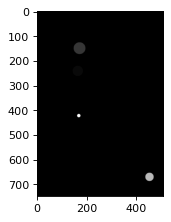

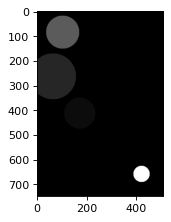

In [20]:
rpop=random_population(10, 4, genotype_len=5, gray=True, max_radius_scale=1/16)
print(MSE_objective_f(represent_individual(rpop[0])))
print(rpop[0])
print(represent_individual(rpop[0]).shape)
draw_individual(represent_individual(rpop[0]))
mutated=rpop[0].copy()
sigmas=np.array([1e-1 , 1e-1   , 1e-1  , 1e-1, 1e-1   ])
for i in range(100):
    mutated=mutate_X(mutated, sigmas)
draw_individual(represent_individual(mutated))

In [21]:
def evaluate_individual(evals, i, X, f):
    evals[i]=f(represent_individual(X))

In [48]:
def es(
    objective_function, 
    chromosome_length,
    genotype_length,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
    number_of_offspring_per_parent=3, 
    mutation_scale=1e-1,
    max_chromosome_length=256,
    gray=False,
  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1,
    pararell=False
):

   # print(chromosome_length)
    best_solution = np.zeros((max_chromosome_length, genotype_length))
    best_solution_objective_value = np.inf

    
    log_objective_values = np.zeros((number_of_iterations, 4))
    log_best_solutions = []#np.zeros((number_of_iterations, max_chromosome_length, genotype_length))
   # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions=random_population(population_size, chromosome_length, genotype_length, gray)
    # current_population_solutions[::2]=0.5
    # SIGMAS individualXcircle parameters (mutation scale)
    current_population_sigmas = 5e-2 * np.ones((population_size, genotype_length))

    # evaluating the objective function on the current population
    current_population_objective_values=np.ones(current_population_solutions.shape[0])
    if pararell:
        threads=[]
        for i in range(population_size):
            t=th.Thread(target=evaluate_individual, args=[current_population_objective_values, i,
                                                          current_population_solutions[i], objective_function])
            t.start()
            threads.append(t)
        for t in threads:
            t.join()
    else:
        current_population_objective_values = np.asarray([objective_function(represent_individual(X)) for X in current_population_solutions])
    #objective_function(current_population_solutions)
  #  print(current_population_objective_values)
    try:
        times_circles_were_added=1 # initial creation of population
        last_update_iter=0
        start_mutations_scale=mutation_scale
        for no_iter in progress_bar(range(number_of_iterations)):

            # selecting the parent indices by the roulette wheel method
            # MAXIMIZE
            #fitness_values = current_population_objective_values - current_population_objective_values.min()
            # MINIMIZE
            fitness_values = current_population_objective_values.max() - current_population_objective_values
            if fitness_values.sum() > 0:
                fitness_values = fitness_values / fitness_values.sum()
            else:
                fitness_values = 1.0 / population_size * np.ones(population_size)
            parent_indices = np.random.choice(population_size, number_of_parents, True, fitness_values).astype(np.int64)

            # creating the children population by Global Intermediere Recombination
            children_list=[]
            children_sigmas_list=[]
            for i in range(number_of_offspring_per_parent):
                children_list.append(current_population_solutions[parent_indices].copy())          
                children_sigmas_list.append(current_population_sigmas[parent_indices].copy())          
            children_population_solutions = np.vstack(children_list)
            children_population_sigmas = np.vstack(children_sigmas_list)
            
        #    for i in range(children_population_solutions.shape[0]):
         #       children_population_solutions[i]=mutate_X(children_population_solutions[i], 
          #                                                scale=mutation_scale)
            
            children_population_sigmas=mutate_sigmas(children_population_sigmas)
            if pararell:
                threads=[]
                for i in range(children_population_solutions.shape[0]):
                    t=th.Thread(target=mutate_X_thred, args=[children_population_solutions, i, 
                                                             children_population_sigmas])
                    t.start()
                    threads.append(t)
                for t in threads:
                    t.join()
            else:
                for i in range(children_population_solutions.shape[0]):
                    children_population_solutions[i]=mutate_X(children_population_solutions[i], 
                                                              children_population_sigmas[i])
            #children_population_solutions=mutate_population(children_population_solutions,
            #                                               scale=mutation_scale)
            
            
            #np.empty((number_of_offspring, chromosome_length), dtype=Circle)
            #children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))

           # for i in range(number_of_offspring):
            #    children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
             #   children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

            # mutating the children population by adding random gaussian noise
          #  children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
           # children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

            # evaluating the objective function on the children population
            children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
            if pararell:
                threads=[]
                for i in range(children_population_solutions.shape[0]):
                    t=th.Thread(target=evaluate_individual, args=[children_population_objective_values, i,
                                                                  children_population_solutions[i], objective_function])
                    t.start()
                    threads.append(t)
                for t in threads:
                    t.join()
            else:
                children_population_objective_values = [objective_function(represent_individual(X)) for X in children_population_solutions]

            # replacing the current population by (Mu + Lambda) Replacement
            current_population_objective_values = np.hstack([current_population_objective_values, 
                                                             children_population_objective_values])
            current_population_solutions = np.vstack([current_population_solutions, 
                                                      children_population_solutions])
            current_population_sigmas = np.vstack([current_population_sigmas, 
                                                   children_population_sigmas])

            I = np.argsort(current_population_objective_values)#[::-1]
            current_population_solutions = current_population_solutions[I[:population_size], :]
            current_population_sigmas = current_population_sigmas[I[:population_size], :]
            current_population_objective_values = current_population_objective_values[I[:population_size]]

            # recording some statistics
            if best_solution_objective_value > current_population_objective_values[0]:
                best_solution = current_population_solutions[0, :]
                best_solution_objective_value = current_population_objective_values[0]

            log_objective_values[no_iter, :] = [current_population_objective_values.min(), 
                                                current_population_objective_values.max(),
                                                current_population_objective_values.mean(), 
                                                current_population_objective_values.std()]

            if np.mod(no_iter, log_frequency) == 0 or no_iter==number_of_iterations-1:
                
                log_best_solutions.append(current_population_solutions[0, :])
                print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                    log_objective_values[no_iter, 0], 
                                                                                    log_objective_values[no_iter, 2]))
                #draw_individual(represent_individual(best_solution), gray)
                save_individual_img(represent_individual(best_solution), gray, no_iter=no_iter)
                
                if no_iter-last_update_iter>=times_circles_were_added*400 and \
                   no_iter>2*log_frequency and \
                   current_population_solutions.shape[1]<max_chromosome_length:
                    
                    prev=np.mean(log_objective_values[no_iter-2*log_frequency:no_iter-log_frequency])
                    curr=np.mean(log_objective_values[no_iter-log_frequency:no_iter+1])
                    if (prev-curr)/prev < 0.005: # ADD CIRCLES
                        
                        last_update_iter=no_iter
                        times_circles_were_added+=1
                        best_solution_objective_value=np.inf
                        mutation_scale=start_mutations_scale/times_circles_were_added
                        
                        radius_scale=1/(2*times_circles_were_added)
                        if radius_scale<1/16:
                            radius_scale=1/16
                                
                        new_pop=random_population(population_size, 2*chromosome_length, 
                                                  genotype_length, gray, 
                                                  max_radius_scale=radius_scale,
                                                  max_opacity_scale=0.5)
                        current_population_solutions=np.concatenate([current_population_solutions, new_pop], 
                                                                    axis=1)
                        print(f'Added more circles of radius_scale={radius_scale}, mutation scale={mutation_scale}.\n New population shape: {current_population_solutions.shape}')
                        print('Sigmas: ', current_population_sigmas)
                        if pararell:
                            threads=[]
                            for i in range(population_size):
                                t=th.Thread(target=evaluate_individual, args=[current_population_objective_values, i,
                                                                              current_population_solutions[i], objective_function])
                                t.start()
                                threads.append(t)
                            for t in threads:
                                t.join()
                        else:
                            current_population_objective_values = np.asarray([objective_function(represent_individual(X)) for X in current_population_solutions])

        
    except KeyboardInterrupt:
        print('Interrupted')
    return (best_solution_objective_value, best_solution, 
            log_objective_values, log_best_solutions, 
            current_population_solutions, current_population_sigmas)

  0%|                                                 | 0/30000 [00:00<?, ?it/s]

Iteration 0000 : best score = 5099.90826762, mean score = 11196.38084413.


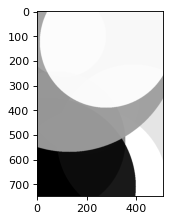

  0%|                                     | 100/30000 [00:34<3:04:14,  2.70it/s]

Iteration 0100 : best score = 2682.76982043, mean score = 2686.76942623.


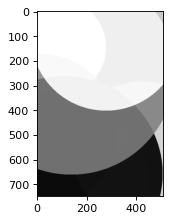

  1%|▏                                    | 200/30000 [01:10<2:55:29,  2.83it/s]

Iteration 0200 : best score = 2604.92413837, mean score = 2607.95243194.


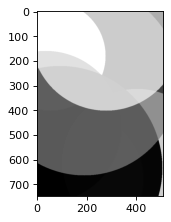

  1%|▎                                    | 264/30000 [01:32<2:54:06,  2.85it/s]

Interrupted


In [24]:
'''def es(
    objective_function, 
    individual_size,
    population_size, 
    number_of_iterations, 
    number_of_parents, 
number_of_offspring_per_parent  #  sigma, 
  #  tau, 
  #  tau_0, 
    log_frequency=1
):'''
no_iters=30000


best_solution_objective_value, best_solution, \
log_objective_values, log_best_solutions, \
population, sigmas=es(MSE_objective_f, 
                      chromosome_length=8,
                      population_size=32,
                      number_of_iterations=no_iters,
                      number_of_parents=6,
                      number_of_offspring_per_parent=6,

                      genotype_length=5, gray=True,

                      pararell=True, log_frequency=100)